In [1]:
import preprocess
from sklearn.preprocessing import StandardScaler as scaler
import pandas as pd
import numpy as np

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
train = pd.read_csv('/home/dileep/Desktop/python/All_csvs/process.csv', )

# Defining and naming columns
train.columns = ['Unnamed: 0', 'Name', 'CPMRN', 'Month of Admission', 'Age', 'Gender',
       'Hospital', 'Surgery', 'Vent mode', 'GCS', 'Temperature', 'HR', 'SpO2',
       'SBP', 'MAP', 'RR', 'FiO2', 'PaO2', 'PaCO2', 'pH', 'A-a gradient',
       'HCO3', 'Hb', 'TLC', 'Platelets', 'K', 'Na', 'Serum Cr', 'Blood Urea',
       'Bili', 'Urine output', 'Lactate', 'INR', 'Survival']
to_drop = ['Unnamed: 0', 'Name', 'CPMRN', 'SBP', 'A-a gradient', 'Month of Admission', 
           'HCO3', 'Hospital', 'Vent mode']
numerics = ['Age', 'Temperature', 'GCS', 'HR', 'SpO2', 'Hb', 'TLC', 'Platelets', 'K',
            'MAP', 'RR', 'FiO2', 'PaO2', 'PaCO2', 'pH', 'Na', 'Serum Cr', 'Blood Urea', 
            'Bili', 'Urine output', 'Lactate', 'INR']
categoricals = ['Gender', 'Surgery', 'Survival']

# Changing types and dropping columns
df_train = preprocess.changeTypes(train).dropAndChange(to_drop, numerics, categoricals)

# Removing and replacing bad values
df_train = preprocess.changeBad.change(df_train)

# Imputation of Na values
df_train = preprocess.Impute(df_train).impute(numerics, categoricals)
df_train_unscaled = pd.DataFrame.copy(df_train)

# Encoding df_train_unscaled
survival = {'Alive': 0,'Expired': 1} 
df_train_unscaled['Survival'] = [survival[item] for item in df_train_unscaled['Survival']] 


In [4]:
holdout = pd.read_csv('/home/dileep/Desktop/python/All_csvs/holdout.csv')

# Defining and naming columns
holdout.columns = ['Unnamed: 0', 'Name', 'CPMRN', 'Month of Admission', 'Age', 'Gender',
       'Hospital', 'Surgery', 'Vent mode', 'GCS', 'Temperature', 'HR', 'SpO2',
       'SBP', 'MAP', 'RR', 'FiO2', 'PaO2', 'PaCO2', 'pH', 'A-a gradient',
       'HCO3', 'Hb', 'TLC', 'Platelets', 'K', 'Na', 'Serum Cr', 'Blood Urea',
       'Bili', 'Urine output', 'Lactate', 'INR', 'Survival']
to_drop = ['Unnamed: 0', 'Name', 'CPMRN', 'SBP', 'A-a gradient', 'Month of Admission', 
           'HCO3', 'Hospital', 'Vent mode']
numerics = ['Age', 'Temperature', 'GCS', 'HR', 'SpO2', 'Hb', 'TLC', 'Platelets', 'K',
            'MAP', 'RR', 'FiO2', 'PaO2', 'PaCO2', 'pH', 'Na', 'Serum Cr', 'Blood Urea', 
            'Bili', 'Urine output', 'Lactate', 'INR']
categoricals = ['Gender', 'Surgery', 'Survival']

# Changing types and dropping columns
holdout1 = preprocess.changeTypes(holdout).dropAndChange(to_drop, numerics, categoricals)

# Removing and replacing bad values
holdout2 = preprocess.changeBad.change(holdout1)

# Imputation of Na values
holdout3 = preprocess.Impute(holdout2).impute(numerics, categoricals)
holdout3_unscaled = pd.DataFrame.copy(holdout3)

# Encoding holdout3_unscaled
survival = {'Alive': 0,'Expired': 1} 
holdout3_unscaled['Survival'] = [survival[item] for item in holdout3_unscaled['Survival']] 


## Trop and Apache

In [5]:
score_train = pd.read_csv('/home/dileep/Desktop/python/All_csvs/score_train.csv')
score_holdout = pd.read_csv('/home/dileep/Desktop/python/All_csvs/score_holdout.csv')
score_all = pd.read_csv('/home/dileep/Desktop/python/All_csvs/score_all.csv')

In [6]:
survival = {'Alive': 0,'Expired': 1} 
score_all['Survival'] = [survival[item] for item in score_all['Survival']]

In [7]:
# Whole dataset for evaluation - No splitting
trop_all = (score_all['T Pred Mort'])/100
ap_all = (score_all['A PredMort'])/100
sur_all = score_all['Survival']

In [8]:
# Just holdout
trop_h = (score_holdout['T Pred Mort'])/100
ap_h = (score_holdout['A PredMort'])/100
sur_h = score_holdout['Survival']

In [9]:
apache_trop = [trop_all, ap_all, sur_all]

## Training

In [10]:
# from sklearn.compose import ColumnTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import GradientBoostingRegressor, AdaBoostClassifier, RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor

SEED = 62

numeric_features = ['Age', 'Temperature', 'GCS', 'HR', 'SpO2', 'Hb', 'TLC', 'Platelets', 'K',
            'MAP', 'RR', 'FiO2', 'PaO2', 'PaCO2', 'pH', 'Na', 'Serum Cr', 'Blood Urea', 
            'Bili', 'Urine output', 'Lactate', 'INR']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['Gender', 'Surgery']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='error'))])

'''
Column Transformer
``````````````````
This estimator allows different columns or column subsets of the input to be transformed 
separately and the features generated by each transformer will be concatenated to form a 
single feature space. This is useful for heterogeneous or columnar data, to combine several 
feature extraction mechanisms or transformations into a single transformer.
'''

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


# Creating pipes
pipe_lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('clf', LogisticRegression(random_state=42))])
pipe_dtr = Pipeline(steps=[('preprocessor', preprocessor),
                          ('clf', DecisionTreeRegressor(random_state=42))])
pipe_kn = Pipeline(steps=[('preprocessor', preprocessor),
                          ('clf', KNeighborsRegressor())])
pipe_br = Pipeline(steps=[('preprocessor', preprocessor), 
                          ('clf', BaggingRegressor(base_estimator=(DecisionTreeRegressor(random_state=SEED,
                                                            max_depth=5, min_samples_leaf=0.1))))])
pipe_rf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('clf', RandomForestRegressor(random_state=42))])
pipe_brf = Pipeline(steps=[('preprocessor', preprocessor), 
                          ('clf', BaggingRegressor(base_estimator=RandomForestRegressor(max_depth=8, 
                                                                                         max_leaf_nodes=8, 
                                                                                         min_impurity_split=0.01, 
                                                                                         n_estimators=50)))])
pipe_gb = Pipeline(steps=[('preprocessor', preprocessor), 
                         ('clf', GradientBoostingRegressor())])
pipe_sgb = Pipeline(steps=[('preprocessor', preprocessor), 
                         ('clf', GradientBoostingRegressor())])

# Creating params
params_lr = {
    'clf__C' : [0.001, 0.01, 0.1, 1],
    'clf__penalty' : ['l1', 'l2']
}
params_dtr = {
    'clf__max_depth' : np.arange(1,20,5),
    'clf__min_samples_leaf' : [0.05, 0.1]
}
params_kn = {
    'clf__n_neighbors' : np.arange(30,50,10)
}
params_br = {
    'clf__n_estimators' : np.arange(30,100,10),
}
params_rf = {
    'clf__max_depth' : np.arange(2, 20, 6),
    'clf__max_leaf_nodes': np.arange(2,20,6), 
    'clf__min_impurity_split': [0.01, 0.1],
    'clf__n_estimators': np.arange(50, 70, 10)
}
params_brf = {
    'clf__n_estimators' : [90],
}
params_gb = {
    'clf__n_estimators': [20],
    'clf__learning_rate': [0.1], 
    'clf__max_depth': [4]
}
params_sgb = {
    'clf__n_estimators': [20],
    'clf__learning_rate': [0.1], 
    'clf__max_depth': [4], 
    'clf__subsample': [0.8], 
    'clf__max_features': [0.2]
}


# Construct grid searches
jobs = -1

gs_lr = GridSearchCV(estimator=pipe_lr, 
                    param_grid=params_lr,
                    scoring='roc_auc',
                    cv=5)

gs_dtr = GridSearchCV(estimator=pipe_dtr, 
                    param_grid=params_dtr,
                    scoring='roc_auc',
                    cv=5)
grid_kn = GridSearchCV(estimator=pipe_kn, 
                      param_grid=params_kn, 
                      scoring='roc_auc', 
                      cv=5)
grid_br = GridSearchCV(estimator=pipe_br, 
                      param_grid=params_br, 
                      scoring='roc_auc', 
                      cv=5)
grid_rf = GridSearchCV(estimator=pipe_rf, 
                      param_grid=params_rf, 
                      scoring='roc_auc', 
                      cv=5)
grid_brf = GridSearchCV(estimator=pipe_brf, 
                      param_grid=params_brf, 
                      scoring='roc_auc', 
                      cv=5)
grid_gb = GridSearchCV(estimator=pipe_gb, 
                      param_grid=params_gb, 
                      scoring='roc_auc', 
                      cv=5)
grid_sgb = GridSearchCV(estimator=pipe_sgb, 
                      param_grid=params_sgb, 
                      scoring='roc_auc', 
                      cv=5)

# List of pipelines
grids = [grid_sgb, grid_gb, grid_brf, grid_rf, grid_br, grid_kn, gs_dtr, gs_lr, 1]

# Dictionary of pipelines
grid_dict = {0: 'Stochastic Gradient Boost', 1: 'Gradient Boost', 2: 'RF with bagging', 
             3: 'RandomForestRegressor', 4: 'BaggingRegressor', 5: 'KNeighborsRegressor', 6: 'DecisionTree', 
             7: 'Logistic Regression', 8: 'Neural Net'}

# Fitting
print('Performing model optimizations...')

X = df_train_unscaled.drop('Survival', axis=1)
y = df_train_unscaled['Survival']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=62)

for idx, gs in enumerate(grids):
    if (grid_dict[idx] == 'Neural Net'):
        print('\nEstimator: %s' % grid_dict[idx])
        fin_nn, targ_nn = preprocess.NNProcess(df_train_unscaled).NNdataprocess()
        
        # Creating NN model
        nn_model = Sequential()
        nn_model.add(Dense(128, activation='relu', input_shape=(25,)))
        nn_model.add(Dropout(1))
        nn_model.add(Dense(128, activation='relu'))
        nn_model.add(Dropout(1))
        nn_model.add(Dense(128, activation='relu'))
        nn_model.add(Dropout(1))
        nn_model.add(Dense(128, activation='relu'))
        nn_model.add(Dropout(1))
        nn_model.add(Dense(128, activation='relu'))
        nn_model.add(Dropout(1))
        nn_model.add(Dense(128, kernel_regularizer=regularizers.l2(0.1), activation='relu'))
        nn_model.add(Dense(1))
        # Compiling
        nn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
        
        nn_model.fit(fin_nn, targ_nn)
        y_pred = nn_model.predict(fin_nn)
        # Scoring
        print('Train set accuracy score for best param: %.3f ' % roc_auc_score(targ_nn, y_pred))
        break
    else:
        print('\nEstimator: %s' % grid_dict[idx])
        # Fit grid search
        gs.fit(X_train, y_train)
        # Best params
        print('Best params: %s' % gs.best_params_)
        # Best training data accuracy
        print('Best training accuracy: %.3f' % gs.best_score_)
        if (grid_dict[idx] == 'Logistic Regression'):
            y_pred = gs.predict_proba(X_test)[:, 1]
        else:
            # Predict on test data with best params
            y_pred = gs.predict(X_test)
        # Test data accuracy of model with best params
        print('Test set accuracy score for best params: %.3f ' % roc_auc_score(y_test, y_pred))

Using TensorFlow backend.


Performing model optimizations...

Estimator: Stochastic Gradient Boost
Best params: {'clf__learning_rate': 0.1, 'clf__max_depth': 4, 'clf__max_features': 0.2, 'clf__n_estimators': 20, 'clf__subsample': 0.8}
Best training accuracy: 0.795
Test set accuracy score for best params: 0.806 

Estimator: Gradient Boost
Best params: {'clf__learning_rate': 0.1, 'clf__max_depth': 4, 'clf__n_estimators': 20}
Best training accuracy: 0.797
Test set accuracy score for best params: 0.772 

Estimator: RF with bagging
Best params: {'clf__n_estimators': 90}
Best training accuracy: 0.811
Test set accuracy score for best params: 0.785 

Estimator: RandomForestRegressor
Best params: {'clf__max_depth': 8, 'clf__max_leaf_nodes': 8, 'clf__min_impurity_split': 0.01, 'clf__n_estimators': 50}
Best training accuracy: 0.800
Test set accuracy score for best params: 0.798 

Estimator: BaggingRegressor
Best params: {'clf__n_estimators': 50}
Best training accuracy: 0.775
Test set accuracy score for best params: 0.801 


In [11]:
models = [grid_sgb.best_estimator_, grid_gb.best_estimator_, 
              grid_brf.best_estimator_, grid_rf.best_estimator_, 
              grid_br.best_estimator_, grid_kn.best_estimator_, 
              gs_dtr.best_estimator_, gs_lr.best_estimator_, nn_model]

In [12]:
case_tr = preprocess.evaluate(df_train_unscaled).testPerformance(data_type='train', 
                                                              models=models, ap_tr_list=apache_trop)

Arranging Models...
Evaluating performance...
Preparing dataset...
Evaluating...

Estimator: Stochastic Gradient Boost
Score in training set: 0.9345586886638542
Confidence interval for the score: [0.907 - 0.961]
Optimal threshold in training set is: 0.123
Preparing dataset...
Evaluating...

Estimator: Gradient Boost
Score in training set: 0.9198756624738149
Confidence interval for the score: [0.886 - 0.951]
Optimal threshold in training set is: 0.106
Preparing dataset...
Evaluating...

Estimator: RF with batch aggregation
Score in training set: 0.9525335701667166
Confidence interval for the score: [0.938 - 0.966]
Optimal threshold in training set is: 0.035
Preparing dataset...
Evaluating...

Estimator: Random Forest
Score in training set: 0.9006409947002095
Confidence interval for the score: [0.859 - 0.938]
Optimal threshold in training set is: 0.04
Preparing dataset...
Evaluating...

Estimator: DT with Batch Aggregation
Score in training set: 0.8509059842261243
Confidence interval for

Arranging Models...
Evaluating performance...
Preparing dataset...
Evaluating...

Estimator: Stochastic Gradient Boost
Score in training set: 0.806113769271664
Confidence interval for the score: [0.727 - 0.877]
Optimal threshold in training set is: 0.027
Preparing dataset...
Evaluating...

Estimator: Gradient Boost
Score in training set: 0.771531100478469
Confidence interval for the score: [0.695 - 0.847]
Optimal threshold in training set is: 0.038
Preparing dataset...
Evaluating...

Estimator: RF with batch aggregation
Score in training set: 0.7850079744816587
Confidence interval for the score: [0.699 - 0.865]
Optimal threshold in training set is: 0.047
Preparing dataset...
Evaluating...

Estimator: Random Forest
Score in training set: 0.7981392876129719
Confidence interval for the score: [0.722 - 0.87]
Optimal threshold in training set is: 0.045
Preparing dataset...
Evaluating...

Estimator: DT with Batch Aggregation
Score in training set: 0.8006911217437532
Confidence interval for t

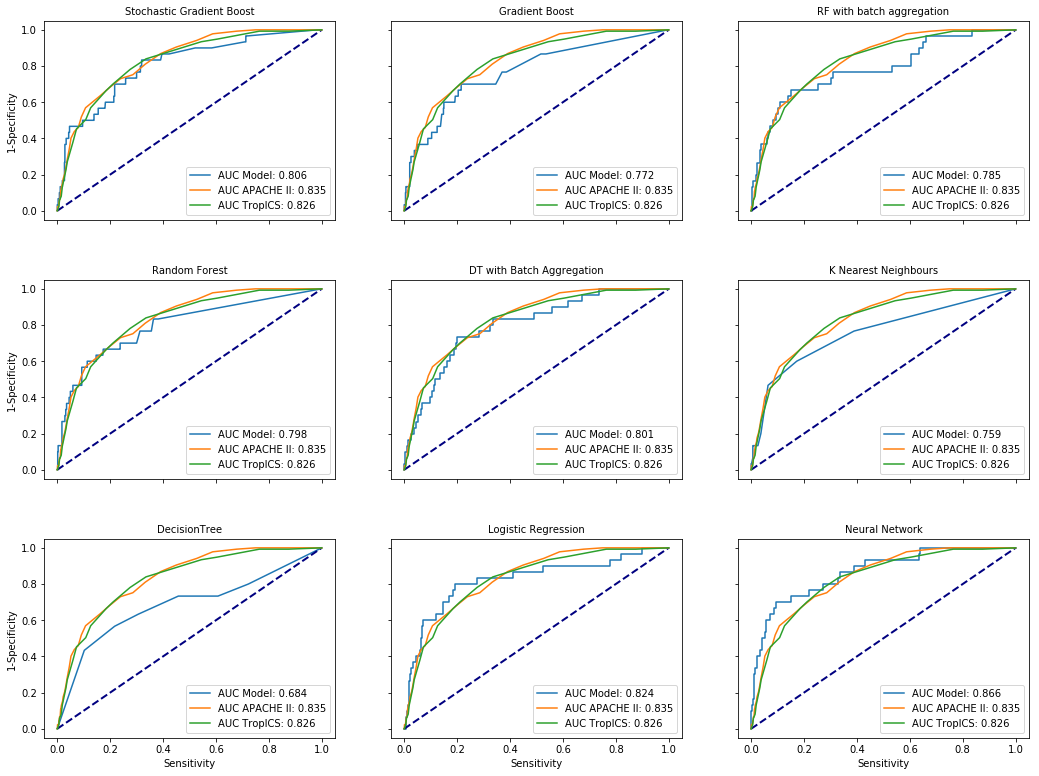

In [13]:
case_ts = preprocess.evaluate(df_train_unscaled).testPerformance(data_type='test', 
                                                              models=models, ap_tr_list=apache_trop)

Arranging Models...
Evaluating performance...
Preparing dataset...
Evaluating...

Estimator: Stochastic Gradient Boost
Score in training set: 0.8384576145427565
Confidence interval for the score: [0.795 - 0.879]
Optimal threshold in training set is: 0.037
Preparing dataset...
Evaluating...

Estimator: Gradient Boost
Score in training set: 0.827606195511037
Confidence interval for the score: [0.779 - 0.876]
Optimal threshold in training set is: 0.027
Preparing dataset...
Evaluating...

Estimator: RF with batch aggregation
Score in training set: 0.850584307178631
Confidence interval for the score: [0.813 - 0.885]
Optimal threshold in training set is: 0.027
Preparing dataset...
Evaluating...

Estimator: Random Forest
Score in training set: 0.8326609163420515
Confidence interval for the score: [0.783 - 0.88]
Optimal threshold in training set is: 0.029
Preparing dataset...
Evaluating...

Estimator: DT with Batch Aggregation
Score in training set: 0.8212298274902614
Confidence interval for t

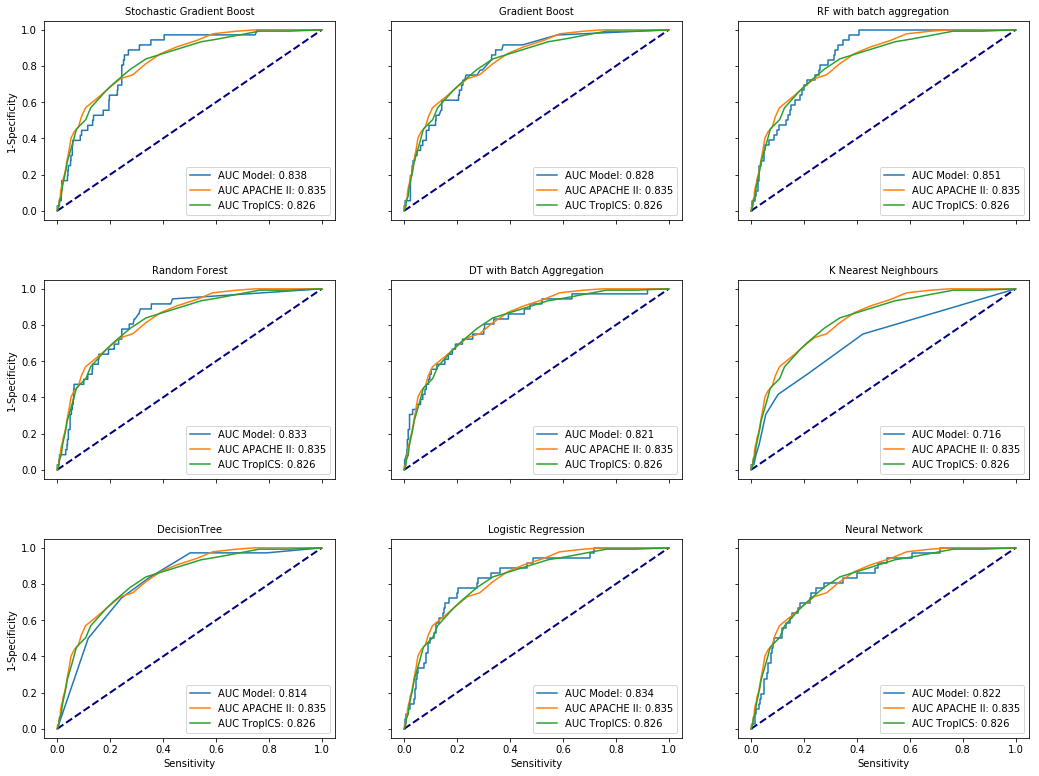

In [14]:
case_h = preprocess.evaluate(holdout3_unscaled).testPerformance(data_type='holdout', 
                                                              models=models, ap_tr_list=apache_trop)